<a href="https://colab.research.google.com/github/adnan-mujagic/steam-recommender-system-using-implicitly-inferred-ratings/blob/main/recommender_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing necessary libraries and the dataset

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

ratings = pd.read_csv("/content/drive/MyDrive/ML/Steam/steam-200k-with-ratings.csv")

ratings.sample(5)

,user_id,game_name,rating
18198,39622853,Cities Skylines,1.677201
35838,177362386,Team Fortress 2,1.380504
64298,247887213,Stranded In Time,2.500000
29619,260567796,Brick-Force,1.531515
101857,172518437,The Elder Scrolls V Skyrim - Dragonborn,2.500000


In [29]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128804 entries, 0 to 128803
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    128804 non-null  int64  
 1   game_name  128804 non-null  object 
 2   rating     128804 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.9+ MB


In [30]:
print("There are", ratings.user_id.nunique(), "users")

print("There are", ratings.game_name.nunique(), "games")

There are 12393 users
There are 5155 games


## Filtering only games with more than N ratings

In [33]:
agg_rating = ratings.groupby("game_name").agg(mean_rating = ("rating", "mean"), number_of_ratings = ("rating", "count")).reset_index()

N = 40

agg_ratings_greater_than_N = agg_rating[agg_rating["number_of_ratings"] > N]

agg_ratings_greater_than_N.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 657 entries, 38 to 5153
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   game_name          657 non-null    object 
 1   mean_rating        657 non-null    float64
 2   number_of_ratings  657 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 20.5+ KB


Take a look at the most commonly played games (the greatest number of reviews)

In [34]:
agg_ratings_greater_than_N.sort_values("number_of_ratings", ascending = False).head()

,game_name,mean_rating,number_of_ratings
1336,Dota 2,1.935240,4841
4257,Team Fortress 2,1.882287,2323
4788,Unturned,2.013671,1563
981,Counter-Strike Global Offensive,2.233448,1412
2074,Half-Life 2 Lost Coast,1.860105,981


## Correlation between average rating and number of ratings
Check whether there is a correlation between average rating of a game and the number of ratings

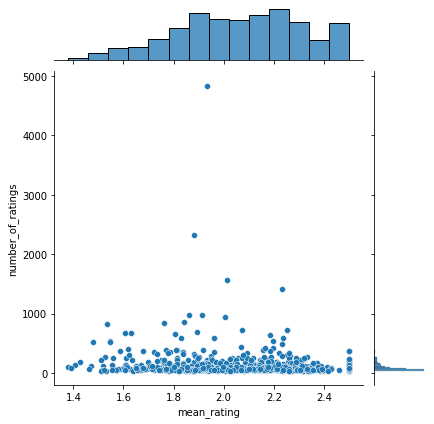

In [35]:
sns.jointplot(x = 'mean_rating', y = 'number_of_ratings', data = agg_ratings_greater_than_N)

From the above plot you can see that most games have between `0 - 1000` ratings, with some outliers reaching almost `5000`, and the average ratings are generally between `1.3` and `2.6`. 

The average rating isn't really affected by the number of ratings as in some other datasets.

Time to merge this data with the original dataset.

In [36]:
df_greater_than_N = pd.merge(ratings, agg_ratings_greater_than_N[["game_name"]], how = "inner", on = "game_name")

df_greater_than_N.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93767 entries, 0 to 93766
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    93767 non-null  int64  
 1   game_name  93767 non-null  object 
 2   rating     93767 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.9+ MB


In [37]:
print("There are", df_greater_than_N.user_id.nunique(), "users")

print("There are", df_greater_than_N.game_name.nunique(), "games")

There are 11871 users
There are 657 games


## User-game matrix
Let's create a user-game matrix.

Rows are `user_id`, columns are `game_name` and values are `rating` if there is one, otherwise `NaN`.

In [38]:
# Create user-item matrix
matrix = df_greater_than_N.pivot_table(index = 'user_id', columns = 'game_name', values = 'rating')
matrix.head()

game_name,7 Days to Die,8BitMMO,A.V.A - Alliance of Valiant Arms,APB Reloaded,ARK Survival Evolved,Ace of Spades,AdVenture Capitalist,Afterfall InSanity Extended Edition,Aftermath,Age of Chivalry,...,Worms Reloaded,Worms Revolution,X-COM UFO Defense,XCOM Enemy Unknown,XCOM Enemy Within,You Have to Win the Game,Zombie Panic Source,Zombies Monsters Robots,sZone-Online,theHunter
user_id,,,,,,,,,,,,,,,,,,,,,
5250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.415882,NaN,NaN,NaN,NaN,NaN,NaN
103360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Matrix Normalization
Since some people generally play games more than others, and therefore their ratings are naturally better than the ratings of others (since hours played are used to implicitly infer ratings), we need to normalize the data.

In [39]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis = 1), axis = 'rows')
matrix_norm.head()

game_name,7 Days to Die,8BitMMO,A.V.A - Alliance of Valiant Arms,APB Reloaded,ARK Survival Evolved,Ace of Spades,AdVenture Capitalist,Afterfall InSanity Extended Edition,Aftermath,Age of Chivalry,...,Worms Reloaded,Worms Revolution,X-COM UFO Defense,XCOM Enemy Unknown,XCOM Enemy Within,You Have to Win the Game,Zombie Panic Source,Zombies Monsters Robots,sZone-Online,theHunter
user_id,,,,,,,,,,,,,,,,,,,,,
5250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.808209,NaN,NaN,NaN,NaN,NaN,NaN
103360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Identifying similar users
Using Pearson similarity

In [40]:
user_similarity = matrix_norm.T.corr()
user_similarity.head()

user_id,5250,76767,86540,103360,144736,181212,229911,298950,299153,381543,...,309262440,309265377,309375103,309404240,309434439,309554670,309626088,309812026,309824202,309903146
user_id,,,,,,,,,,,,,,,,,,,,,
5250,1.000000,0.071127,-0.106896,NaN,NaN,NaN,-0.144744,0.195178,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76767,0.071127,1.000000,0.044832,NaN,0.955043,0.953439,0.796622,-0.115561,NaN,0.955043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86540,-0.106896,0.044832,1.000000,NaN,NaN,NaN,-0.133680,0.508789,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144736,NaN,0.955043,NaN,NaN,1.000000,1.000000,0.592857,1.000000,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Finding similar users

In [41]:
picked_user_id = 5250


# First drop the picked user
user_similarity.drop(index=picked_user_id, inplace = True)
# Take a look at the data
user_similarity.head()

user_id,5250,76767,86540,103360,144736,181212,229911,298950,299153,381543,...,309262440,309265377,309375103,309404240,309434439,309554670,309626088,309812026,309824202,309903146
user_id,,,,,,,,,,,,,,,,,,,,,
76767,0.071127,1.000000,0.044832,NaN,0.955043,0.953439,0.796622,-0.115561,NaN,0.955043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86540,-0.106896,0.044832,1.000000,NaN,NaN,NaN,-0.133680,0.508789,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144736,NaN,0.955043,NaN,NaN,1.000000,1.000000,0.592857,1.000000,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181212,NaN,0.953439,NaN,NaN,1.000000,1.000000,0.976537,-0.137442,NaN,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In the user similarity matrix, `1` means same game preferences, while `-1` means "opposite" game preferences.

## Finding K similar users

In [43]:
K = 10

threshold = 0.3

similar_users = user_similarity[user_similarity[picked_user_id] > threshold][picked_user_id].sort_values(ascending = False)[:K]

similar_users

user_id
58893462     1.0
208491021    1.0
186517004    1.0
120838793    1.0
131940023    1.0
208879416    1.0
133268706    1.0
172105480    1.0
133964193    1.0
72387826     1.0
Name: 5250, dtype: float64

Remove games already played by the target user

In [46]:
picked_user_id_played = matrix_norm[matrix_norm.index == picked_user_id].dropna(axis = 1, how = 'all')
picked_user_id_played

game_name,Alien Swarm,Cities Skylines,Counter-Strike,Counter-Strike Source,Day of Defeat,Deathmatch Classic,Deus Ex Human Revolution,Dota 2,Half-Life,Half-Life 2,...,Half-Life 2 Episode One,Half-Life 2 Episode Two,Half-Life 2 Lost Coast,Half-Life Blue Shift,Half-Life Opposing Force,Portal,Portal 2,Ricochet,Team Fortress 2,Team Fortress Classic
user_id,,,,,,,,,,,,,,,,,,,,,
5250,0.67341,3.191632,-0.408067,-0.408067,-0.408067,-0.408067,2.548304,-0.407097,-0.408067,-0.408067,...,-0.408067,-0.408067,-0.408067,-0.408067,-0.408067,-0.408067,0.512279,-0.408067,-0.397522,-0.408067


In [47]:
# Games that similar users played. Remove games that none of the similar users have played
similar_user_games = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_games

game_name,7 Days to Die,ARK Survival Evolved,Age of Empires II HD Edition,AirMech,America's Army Proving Grounds,Archeblade,Arma 2,Arma 2 British Armed Forces,Arma 2 DayZ Mod,Arma 2 Operation Arrowhead,...,The Witcher Enhanced Edition,Toribash,Total War ROME II - Emperor Edition,Tribes Ascend,Trine,Trine 2,Unturned,War Thunder,Warframe,sZone-Online
user_id,,,,,,,,,,,,,,,,,,,,,
58893462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.026857,NaN,NaN,NaN
72387826,NaN,NaN,NaN,-0.241458,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.241458,NaN,-0.241458
120838793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.041734,NaN
131940023,2.531883,-1.115174,1.131844,NaN,-0.931775,NaN,-0.990336,-1.122259,-1.122259,2.50711,...,NaN,2.533034,NaN,-1.122259,NaN,NaN,-0.708484,NaN,NaN,NaN
133268706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133964193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172105480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186517004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.381185,NaN,NaN,NaN,-0.111939,-0.406533,NaN,NaN,NaN,NaN
208491021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.266653,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# Remove the played game from the movie list
similar_user_games.drop(picked_user_id_played.columns, axis = 1, inplace = True, errors = 'ignore')
# Take a look at the data
similar_user_games

game_name,7 Days to Die,ARK Survival Evolved,Age of Empires II HD Edition,AirMech,America's Army Proving Grounds,Archeblade,Arma 2,Arma 2 British Armed Forces,Arma 2 DayZ Mod,Arma 2 Operation Arrowhead,...,The Witcher Enhanced Edition,Toribash,Total War ROME II - Emperor Edition,Tribes Ascend,Trine,Trine 2,Unturned,War Thunder,Warframe,sZone-Online
user_id,,,,,,,,,,,,,,,,,,,,,
58893462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.026857,NaN,NaN,NaN
72387826,NaN,NaN,NaN,-0.241458,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.241458,NaN,-0.241458
120838793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.041734,NaN
131940023,2.531883,-1.115174,1.131844,NaN,-0.931775,NaN,-0.990336,-1.122259,-1.122259,2.50711,...,NaN,2.533034,NaN,-1.122259,NaN,NaN,-0.708484,NaN,NaN,NaN
133268706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133964193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172105480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186517004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.381185,NaN,NaN,NaN,-0.111939,-0.406533,NaN,NaN,NaN,NaN
208491021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.266653,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There used to be 97 games in the simliar user games matrix, now there are 94, meaning 3 games that the picked user has already played were removed.

In [49]:
# A dictionary to store item scores
item_score = {}
# Loop through items
for i in similar_user_games.columns:
  # Get the ratings for game i
  game_rating = similar_user_games[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the game has rating
    if pd.isna(game_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the game rating
      score = similar_users[u] * game_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count
# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns = ['game', 'game_score'])
    
# Sort the games by score
ranked_item_score = item_score.sort_values(by = 'game_score', ascending = False)
# Select top M games
M = 10
ranked_item_score.iloc[:M]

,game,game_score
59,Nosgoth,2.714148
68,SMITE,2.710888
85,Toribash,2.533034
25,DayZ,2.532951
0,7 Days to Die,2.531883
9,Arma 2 Operation Arrowhead,2.507110
74,Star Wars Knights of the Old Republic,2.407224
69,STAR WARS Knights of the Old Republic II The S...,2.376246
44,GunZ 2 The Second Duel,2.349603
71,Sid Meier's Civilization V,2.336885


## Converting everything into a single method
Improving the usability of the recommender system

In [75]:
class GameRecommenderSystem:
  """
  Ratings dataset is assumed to have the columns: user_id, game_name, and rating
  """
  def __init__(self, ratings_dataset, min_ratings = 40):
    self._ratings = ratings_dataset
    self._agg_ratings_greater_than_min = self._get_games_with_min_ratings(min_ratings)
    self._df_greater_than_N = pd.merge(self._ratings, self._agg_ratings_greater_than_min[["game_name"]], how = "inner", on = "game_name")


  def _get_games_with_min_ratings(self, min_ratings):
    agg_rating = ratings.groupby("game_name").agg(mean_rating = ("rating", "mean"), number_of_ratings = ("rating", "count")).reset_index()
    agg_ratings_greater_than_min = agg_rating[agg_rating["number_of_ratings"] > min_ratings]
    return agg_ratings_greater_than_min


  def fit(self):
    self._matrix = self._df_greater_than_N.pivot_table(index = 'user_id', columns = 'game_name', values = 'rating')
    # Normalized matrix
    self._matrix_norm = self._matrix.subtract(self._matrix.mean(axis = 1), axis = 'rows')
    self._user_similarity = self._matrix_norm.T.corr()


  def recommend(self, user_id, N_similar_users = 10, similarity_threshold = 0.3, N_recommendations = 10):
    self._similar_users = self._user_similarity[self._user_similarity[user_id] > similarity_threshold][user_id].sort_values(ascending = False)[:N_similar_users]
    self._picked_user_id_played = self._matrix_norm[self._matrix_norm.index == user_id].dropna(axis = 1, how = 'all')
    self._similar_user_games = self._matrix_norm[self._matrix_norm.index.isin(self._similar_users.index)].dropna(axis=1, how='all')
    # Remove the played game from the movie list
    self._similar_user_games.drop(self._picked_user_id_played.columns, axis = 1, inplace = True, errors = 'ignore')
    return self._get_recommendations(N_recommendations)


  def _get_recommendations(self, N_recommendations):
    item_score = {}
    # Loop through items
    for i in self._similar_user_games.columns:
      game_rating = self._similar_user_games[i]
      total = 0
      count = 0
      # Loop through similar users
      for u in self._similar_users.index:
        # If the game has rating
        if pd.isna(game_rating[u]) == False:
          # Score is the sum of user similarity score multiply by the game rating
          score = self._similar_users[u] * game_rating[u]
          # Add the score to the total score for the movie so far
          total += score
          # Add 1 to the count
          count +=1
      # Get the average score for the item
      item_score[i] = total / count
    # Convert dictionary to pandas dataframe
    item_score = pd.DataFrame(item_score.items(), columns = ['game', 'game_score'])
        
    # Sort the games by score
    ranked_item_score = item_score.sort_values(by = 'game_score', ascending = False)
    # Select top N_recommendations
    return ranked_item_score.iloc[:N_recommendations]



Getting recommendations for a user in three lines of code: 

In [80]:
# Instantiate class
game_recommender_system = GameRecommenderSystem(ratings)

In [81]:
# Call fit method to generate user-game matrix and normalize it - might take some time
game_recommender_system.fit()

In [82]:
# Call recommend to return recommendations for a particular user - should be very fast
game_recommender_system.recommend(user_id = 5250)

,game,game_score
59,Nosgoth,2.714148
68,SMITE,2.710888
85,Toribash,2.533034
25,DayZ,2.532951
0,7 Days to Die,2.531883
9,Arma 2 Operation Arrowhead,2.507110
74,Star Wars Knights of the Old Republic,2.407224
69,STAR WARS Knights of the Old Republic II The S...,2.376246
44,GunZ 2 The Second Duel,2.349603
71,Sid Meier's Civilization V,2.336885
